In [1]:
import torch
import matplotlib.pyplot as plt
from model import get_model_class
from dataset import PIBDataset
from torch.utils.data import DataLoader
import lightning as L

In [2]:
model_name = 'PIBFilTransformer_v2'

# data_filename = 'data/test/streaming/test.json'  # the labels are set to -1 for the organizers' test set which doesn't have labels
data_filename = 'data/person-in-bed-streaming-detection/train.json'

# data_filename = 'data/test/segmented/test.json'  # the labels are set to -1 for the organizers' test set which doesn't have labels
# data_filename = 'data/icassp-person-in-bed-track-1/train.json'

checkpoint_path = 'results/transformer/lightning_logs/version_16417905/checkpoints/epoch=18-step=458850.ckpt'

train_validate_test_split = [14, 6, 0]

pib_model = get_model_class(model_name).load_from_checkpoint(checkpoint_path)
pib_model.eval()

dataset_val = PIBDataset(mode='validate', data_path=data_filename, train_validate_test_split=train_validate_test_split)
loader_val = DataLoader(dataset_val, batch_size=1024, shuffle=False)

In [3]:
print(len(dataset_val))

6


In [4]:
trainer = L.Trainer(default_root_dir='results/transformer', enable_checkpointing=False, logger=False)
returned_values = trainer.predict(pib_model, loader_val, ckpt_path=checkpoint_path, return_predictions=True)
outputs = torch.cat([returned_value[0] for returned_value in returned_values], dim=0)
labels = torch.cat([returned_value[1] for returned_value in returned_values], dim=0)
model_llrs = torch.cat([returned_value[2] for returned_value in returned_values], dim=0)
ts_list = torch.cat([returned_value[3] for returned_value in returned_values], dim=0)
prev_sums = torch.cat([returned_value[4] for returned_value in returned_values], dim=0)
subjects = torch.cat([returned_value[5] for returned_value in returned_values], dim=0)
# chunk_ids = torch.cat([returned_value[6] for returned_value in returned_values], dim=0)
chunk_ids = torch.arange(len(ts_list))

/scratch/users/akhilb3/pib/venv/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /scratch/users/akhilb3/pib/venv/lib/python3.10/site- ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L40S') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at results/transformer/lightning_logs/version_16417905/checkpoints/epoch=18-step=458850.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded

Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [08:20<00:00,  0.00it/s]


In [5]:
output_filename = 'streaming_test_output.csv'
with open(output_filename, 'w') as f:
    print('id,subject,timestamp,label', file=f)
    # print('chunk_id,label')
    id = 0
    for i in range(len(chunk_ids)):
        for j in range(len(ts_list[i])):
            if ts_list[i][j] < 0:
                break
            print(f'{id},{int(subjects[i])},{ts_list[i][j].item()},{outputs[i][j].item()}', file=f)
            id += 1

In [5]:
new_outputs = outputs
avg_latency_list = []
latency_lists = []
for i in range(len(new_outputs)):
    transitions = torch.arange(1, len(new_outputs[i]), device=new_outputs.device, dtype=torch.long)[(labels[i][1:] - labels[i][:-1]) != 0]
    latency_list = []
    for j in transitions:
        if ts_list[i][j] < 0:
            break
        k = int(j + 0)   # k gets assigned to j's pointer and changes j otherwise
        while k < len(new_outputs[i]):
            if torch.mean((new_outputs[i][k:k+15*250+1] == labels[i][j])*1.0) == 1.:
                break
            k += 1
        latency_list.append((k - j) / 250.)
    if len(latency_list) > 0:
        avg_latency_list.append(torch.mean(torch.tensor(latency_list)))
        latency_lists.append(latency_list)

In [6]:
add_to_list_metric = []
add_to_list_avg = []
for latency_list in latency_lists:
    for latency in latency_list:
        add_to_list_metric.append(torch.exp(-2.*torch.pow(torch.log(1.-latency/60.), 2)))
        add_to_list_avg.append(latency)
print(f'Avg metric: {torch.mean(torch.tensor(add_to_list_metric))}')
print(f'Avg latency: {torch.mean(torch.tensor(add_to_list_avg))} s')

Avg metric: 0.994970440864563
Avg latency: 2.6145713329315186 s


In [7]:
accuracy_list = []
for i in range(len(outputs)):
    accuracy_list.append(torch.mean((outputs[i][ts_list[i]>=0] == labels[i][ts_list[i]>=0])*1.0))
print(f'Accuracy: {torch.mean(torch.tensor(accuracy_list))}')

Accuracy: 0.9856467247009277


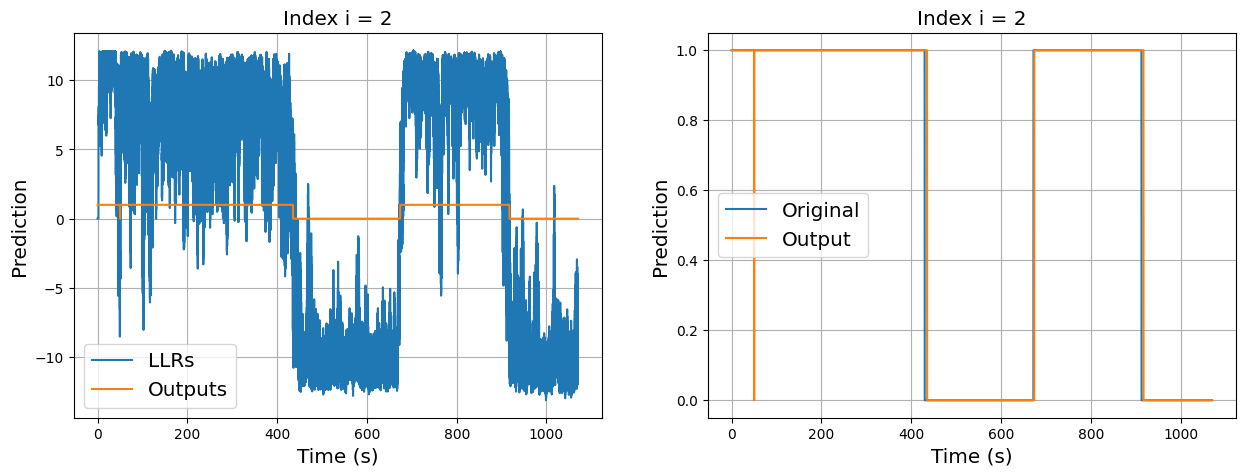

In [8]:
i = torch.randint(0, len(outputs), (1,)).item()
fig, axs = plt.subplots(1, 2, squeeze=False, figsize=(15, 5))
axs[0, 0].plot(torch.arange(len(outputs[i][ts_list[i] >= 0.]))/250., model_llrs[i][ts_list[i] >= 0.], label='LLRs')
axs[0, 0].plot(torch.arange(len(labels[i][ts_list[i] >= 0.]))/250., outputs[i][ts_list[i] >= 0.], label='Outputs')
axs[0, 0].legend(fontsize='x-large')
axs[0, 0].grid()
axs[0, 0].set_xlabel('Time (s)', fontsize='x-large')
axs[0, 0].set_ylabel('Prediction', fontsize='x-large')
axs[0, 0].set_title(f'Index i = {i}', fontsize='x-large')

axs[0, 1].plot(torch.arange(len(outputs[i][ts_list[i] >= 0.]))/250., labels[i][ts_list[i] >= 0.], label='Original')
axs[0, 1].plot(torch.arange(len(labels[i][ts_list[i] >= 0.]))/250., outputs[i][ts_list[i] >= 0.], label='Output')
axs[0, 1].legend(fontsize='x-large')
axs[0, 1].grid()
axs[0, 1].set_xlabel('Time (s)', fontsize='x-large')
axs[0, 1].set_ylabel('Prediction', fontsize='x-large')
axs[0, 1].set_title(f'Index i = {i}', fontsize='x-large')

plt.show()